# Cnn classifier

In this notebook, we implemented a Convolutional Neural Network (CNN) that processes images through convolutional and pooling layers. These layers reduce the original dimensionality of the data while increasing the number of features, thereby extracting meaningful patterns from the input. After this, the data is linearized, and the network is trained to hoppefuly produce a correct output.

### Imports

All the necesssary imports in this notebook

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd
import glob
import os
import librosa
import numpy as np
from librosa.feature import melspectrogram
from itertools import cycle



## 1. Data preparation

This code processes audio data from the UrbanSound8K dataset to prepare features and labels for a machine learning model. The key steps include:

1. Feature Extraction:

    Each WAV file is converted into a log Mel spectrogram using librosa, representing its frequency content.
    Audio is standardized to 4 seconds by either truncating longer files or padding shorter ones by repeating the signal.

2. Label Processing:

    Labels are extracted from the filenames and converted into integers.
    Labels are then one-hot encoded for compatibility with classification models.

3. Data Saving:

    Features and one-hot encoded labels are saved as .npy files for efficient loading and use in subsequent steps.

4. Structure:

    The process is applied to each fold of the UrbanSound8K dataset, and results are saved in a specified output directory.
    This ensures the audio data is preprocessed and organized for easy integration into deep learning pipelines.
5. Hyperparameters:

    A sample rate of 16000 as it containned most of the information with a smaller size that the original
    
    For the n_fft es and hop_length we tested several values but does were the ones that gave enough dimensionality to the data for the model to understand the data and give reseonable results.

In [ ]:


def LOG_MEL_SPEC(parent_dir, sub_dir):
    labels = []
    log_mel_spectrogram = []
    exten = "*.wav"
    
    for filename in glob.glob(os.path.join(parent_dir, sub_dir, exten)):
        label = filename.split('fold')[1].split('-')[1]  
        labels.append(int(label))  
        f, sr = librosa.load(filename, sr=16000)  
        
        # Define target duration (4 seconds)
        four_sec_samples = 4 * sr
        if len(f) >= four_sec_samples:
            # Take first 4 seconds if the audio is long enough
            log_mel_spec = librosa.power_to_db(
                melspectrogram(y=f[:four_sec_samples], sr=sr, n_fft=1024, hop_length=128)
            )
        else:
            # Pad audio to 4 seconds if it's shorter
            while len(f) < four_sec_samples:
                f = np.concatenate((f, f))
            log_mel_spec = librosa.power_to_db(
                melspectrogram(y=f[:four_sec_samples], sr=sr, n_fft=1024, hop_length=128)
            )
        
        log_mel_spectrogram.append(log_mel_spec)
    
    return np.array(log_mel_spectrogram), np.array(labels, dtype=int)

def encode(labels):
    # One hot encoding of labels
    labels_total = len(labels)
    unique_labels_total = len(np.unique(labels))
    one_hot_encoded = np.zeros((labels_total, unique_labels_total))
    one_hot_encoded[np.arange(labels_total), labels] = 1
    return one_hot_encoded

def file_creator(final_path, filename):
    new_path = os.path.join(os.getcwd(), final_path)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    return os.path.join(new_path, filename)

parent_directory = 'UrbanSound8K/audio'  
final_dir = "UrbanSound8K/UrbanSound8K_Processed"

sub_dirs = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']

for sub_dir in sub_dirs:
    print(f"Processing {sub_dir}...")
    features, labels = LOG_MEL_SPEC(parent_directory, sub_dir)
    
    # One hot encode the labels
    labels_encoded = encode(labels)
    
   
    feature_file = file_creator(final_dir, f'{sub_dir}_features.npy')
    labels_file = file_creator(final_dir, f'{sub_dir}_labels.npy')
    
    # Save the extracted features and labels
    np.save(feature_file, features)
    print(f"Saved features for {sub_dir} at {feature_file}")
    np.save(labels_file, labels_encoded)
    print(f"Saved labels for {sub_dir} at {labels_file}")


Processing fold1...
Saved features for fold1 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold1_features.npy
Saved labels for fold1 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold1_labels.npy
Processing fold2...
Saved features for fold2 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold2_features.npy
Saved labels for fold2 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold2_labels.npy
Processing fold3...
Saved features for fold3 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold3_features.npy
Saved labels for fold3 at c:\Users\joaop\OneDrive\Ambiente de Trabalho\Sound_Classification\UrbanSound8K/UrbanSound8K_Processed\fold3_labels.npy
Processing fold4...
Saved features for fold4 at c:\Users\j

An example of the mel spectograms created

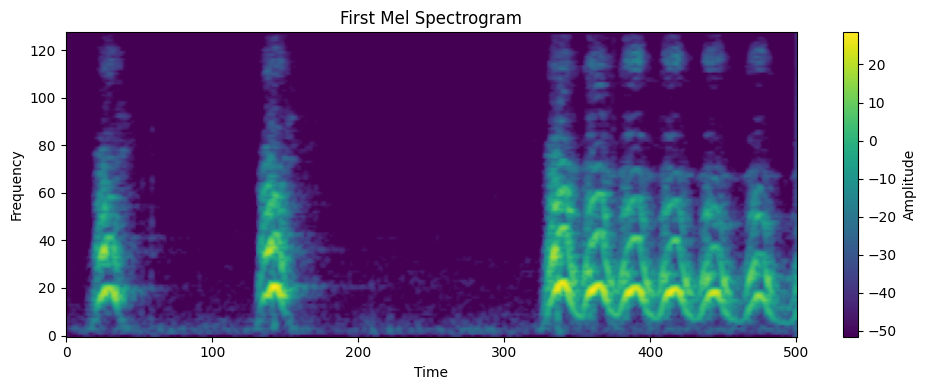

In [ ]:

mel_spectrograms = np.load("UrbanSound8K/UrbanSound8K_Processed/fold1_features.npy")

# Extract the first mel spectrogram
first_mel_spectrogram = mel_spectrograms[0]

# Plot the mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(first_mel_spectrogram, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title('First Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

1. Fold Assignment and Data Preparation
Assigns specific folds for training, validation, and testing, ensuring proper data splits. Also loads preprocessed features and labels.

In [ ]:
processed_dir = 'UrbanSound8K/UrbanSound8K_Processed'
folds = [f'fold{i}' for i in range(1, 11)]  # Folds 1 to 10

test_fold = folds[9]  
validation_fold = folds[8]
train_folds = [fold for fold in folds if fold not in [test_fold, validation_fold]] 

print(f"Training folds: {train_folds}")
print(f"Validation fold: {validation_fold}")
print(f"Test fold: {test_fold}")

Training folds: ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8']
Validation fold: fold9
Test fold: fold10


2. Data Loading Function
Defines a function to load features and labels for specified folds and concatenates them.

In [ ]:
def load_data(folds, processed_dir):
    features_list, labels_list = [], []
    for fold in folds:
        features_file = f"{processed_dir}/{fold}_features.npy"
        labels_file = f"{processed_dir}/{fold}_labels.npy"
        features_list.append(np.load(features_file))
        labels_list.append(np.load(labels_file))
    return np.concatenate(features_list), np.concatenate(labels_list)
X_train, y_train = load_data(train_folds, processed_dir)
X_val, y_val = load_data([validation_fold], processed_dir)
X_test, y_test = load_data([test_fold], processed_dir)

# Reshape features for CNN input: (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

num_classes = 10
y_train = np.reshape(y_train, (-1, num_classes))
y_val = np.reshape(y_val, (-1, num_classes))
y_test = np.reshape(y_test, (-1, num_classes))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (7079, 128, 501, 1), y_train shape: (7079, 10)
X_val shape: (816, 128, 501, 1), y_val shape: (816, 10)
X_test shape: (837, 128, 501, 1), y_test shape: (837, 10)


## 2. CNN Model Architecture

#### 1. Input Layer
- Shape: (128, 251, 1)
    - 128: Number of Mel frequency bins (height).
    - 251: Number of time steps derived from the audio's duration and spectrogram parameters (width).
- 1: Number of channels (grayscale spectrogram).
- Purpose: Processes spectrogram input data for subsequent convolutional layers.
#### 2. First Convolutional Block
Layer: Conv2D with 32 filters, kernel size (3, 3), and activation tanh.
- Extracts low-level features such as edges or simple patterns from the spectrogram.
- Uses 'same' padding to retain the input shape.
- Pooling: MaxPooling2D with pool size (2, 2).
- Reduces the dimensions by half to decrease computational complexity.
#### 3. Second Convolutional Block
Layer: Conv2D with 64 filters, kernel size (3, 3), and activation relu.
- Detects more complex features like texture or frequency patterns.
- Pooling: MaxPooling2D with pool size (2, 2).
- Further reduces dimensions, promoting feature abstraction.
#### 4. Third Convolutional Block
Layer: Conv2D with 128 filters, kernel size (3, 3), and activation relu.
- Captures high-level features, enabling the model to distinguish between classes effectively.
- Pooling: MaxPooling2D with pool size (2, 2).
- Prevents feature map dimensions from collapsing while abstracting further.
#### 5. Global Average Pooling Layer
Layer: GlobalAveragePooling2D.
- Replaces fully connected layers by averaging the feature map across its spatial dimensions.
- Reduces the number of parameters, minimizing overfitting risks.
- Purpose: Converts spatial features into a vector for dense layer input.
#### 6. Dense Layers
First Dense Layer:
- Units: 128 neurons.
- Activation: relu for non-linear transformations.
- Captures high-level abstractions.
Second Dense Layer:
- Units: 64 neurons.
- Activation: relu.
- Refines learned abstractions from the first dense layer.
#### 7. Output Layer
Layer: Fully connected Dense with 10 neurons (number of classes).
- Activation: softmax.
- Converts logits into probabilities, summing to 1, suitable for multi-class classification.
- Purpose: Outputs the predicted probabilities for each class.

### Different things tested in architetural design

- The first activation layer was changed for relu to than as it improved the performance of the model
- Several kernal sizes were tested betwin 2,3 and 4 the first conv layer having a kernal of (4,4) the 3rd having a (2,2), all the convs having (2,2), etc. and from all the tested having all kernal sizes was the one chosen as th other either worsed the runtime or performance or did nothing
- Doubling the number of conv layer betwin maxpooling layers was tested with slightly better performance but much worse runtime
- 3 dense layers architetures were tested direct output, 1 dense layer with 128 filters and 2 dense layers the 1st with 128 filters and the second with 64 filters the best performing one has the one with 1 dense layer
- For the linearization function a Flatten and a Global Average Pooling were tested with the Global Average Pooling having less overfitting and higher performance

In [ ]:

model = models.Sequential([
    layers.InputLayer(input_shape=(128, 251, 1)),
    layers.Conv2D(32, (3, 3), activation='tanh'),  
    layers.MaxPooling2D(pool_size=(2, 2)),  

    layers.Conv2D(64, (3, 3), activation='relu'),  
    layers.MaxPooling2D(pool_size=(2, 2)),  

    layers.Conv2D(128, (3, 3), activation='relu'),  
    layers.MaxPooling2D(pool_size=(2, 2)),  

    layers.GlobalAveragePooling2D(), 
    
    layers.Dense(128, activation='relu'),  
    layers.Dense(10, activation='softmax') 
])

model.summary()

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 249, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 124, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 122, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Generating Noisy Examples

This function creates noisy data samples from misclassified examples in a validation dataset to enhance the training process.

First, the function predicts the labels using the model and compares the predicted labels with the true labels to identify misclassified samples. 

It then calculates the number of noisy examples to generate based on the specified ratio(ex. 50 misclassified with ratio of .1 = 5 noisy), ensuring at least one example is created. 

Then, it randomly selects misclassified samples and for each selected misclassified sample, Gaussian noise is added to its features, and the resulting noisy data is clipped to ensure the values stay within a valid range. 

The function pairs the noisy features with their correct labels, forming a set of new training examples.The generated noisy samples and their labels are returned as outputs.

These examples can be added to the training dataset to improve model performance, particularly by enhancing its ability to generalize and better handle challenging cases, as it introduces variations in the data while emphasizing areas where the model struggles, ultimately improving robustness and decision boundaries.

In [ ]:
def generate_noisy_examples(X, y, model, noise_factor=0.1, ratio=0.1):

    # Predict on the validation data
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y, axis=1)
    
    # Identify misclassified samples
    misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]
        # Determine the number of noisy samples to generate
    num_noisy_samples = max(1, int(len(misclassified_indices) * ratio))  
    print(f"Total misclassified: {len(misclassified_indices)}, Ratio: {ratio}, Noisy samples to generate: {num_noisy_samples}")

    selected_indices = np.random.choice(misclassified_indices, size=num_noisy_samples, replace=False)
    
    X_noisy = []
    y_noisy = []
    
    for idx in selected_indices:
        # Add Gaussian noise to the misclassified sample
        noise = noise_factor * np.random.normal(size=X[idx].shape)
        noisy_sample = np.clip(X[idx] + noise, 0, 1)  # Ensure values are within range
        X_noisy.append(noisy_sample)
        y_noisy.append(y[idx])  # Use the correct label
    
    return np.array(X_noisy), np.array(y_noisy)

This function is used to plot the learning curves for the loss and accuracy of a model with the test result appering in a red line 

In [ ]:
def plot_learning_curve(history, test_loss, test_accuracy, fold_idx):
   
   
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']  
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f"Test Loss: {test_loss:.4f}")
    plt.title(f"Loss Learning Curve for Fold {fold_idx + 1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy, label="Training Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f"Test Accuracy: {test_accuracy:.2f}")
    plt.title(f"Accuracy Learning Curve for Fold {fold_idx + 1}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()


## 4. Training the Model

Trains the model with early stopping, dynamically adds noisy examples, and restores the best weights.

Changes made during the model tranning:

- Tested different learnig rates a learnig rate of .01 was deem to high and made the model unstable and with difficulty converging and a learning rate of .0001 was deem to low as it took way to long to converge so a learnig rate of 0.01 was selected
- The pacience on the early stooper is 6 this value was selected as it seemed to let the model converge before stooping, sometimes the model may stop before fully converging values of 3,5,10 were tested, 3 was to low, 10 toke a lot of time but the model convergency was higher and 5 was used in early training of the model but was latter swapped out with 6 as it alowed for higher convergency without increaing the performance burner to much
- The first batch size used was 64 batches of 32 and 128 were used without significant differencies or worst performance so this value was kept

In [ ]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


history = []  
max_epochs = 50
patience_limit = 30  


early_stop_counter = 0
best_val_loss = float('inf')  

best_weights = None  

for epoch in range(1, max_epochs + 1):
    print(f"Epoch {epoch}/{max_epochs}")

    # Train model for one epoch
    hist = model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=1,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Store history
    history.append(hist.history)

    # Extract validation loss for manual early stopping check
    val_loss = hist.history.get('val_loss', [None])[-1]
    if val_loss is not None:
        print(f"Validation Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.get_weights()  # Save best weights
            early_stop_counter = 0  
        else:
            early_stop_counter += 1  

    
    if early_stop_counter >= patience_limit:
        print(f"Early stopping triggered after {epoch} epochs. Best val_loss: {best_val_loss:.4f}")
        model.set_weights(best_weights)  # Restore the best weights
        break

    # Generate noisy examples
    X_noisy, y_noisy = generate_noisy_examples(X_val, y_val, model, noise_factor=0.05, ratio=0.1)

    # Inject noisy examples back into training
    if len(X_noisy) > 0:
        X_train = np.concatenate([X_train, X_noisy])
        y_train = np.concatenate([y_train, y_noisy])
        print(f"Added {len(X_noisy)} noisy examples to the training set.")



model.save(f"model_test.h5")


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 113s 965ms/step - accuracy: 0.2161 - loss: 2.0914 - val_accuracy: 0.3051 - val_loss: 1.8147
Validation Loss: 1.8147
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step
Total misclassified: 567, Ratio: 0.1, Noisy samples to generate: 56
Added 56 noisy examples to the training set.
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.4501 - loss: 1.5583 - val_accuracy: 0.4743 - val_loss: 1.5023
Validation Loss: 1.5023
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step
Total misclassified: 429, Ratio: 0.1, Noisy samples to generate: 42
Added 42 noisy examples to the training set.
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5402 - loss: 1.3144 - val_accuracy: 0.5135 - val_loss: 1.4011
Validation Loss: 1.4011
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step
Total misclassified: 397, Ratio: 0.1, Noisy samples to generate: 39
Added 39 noisy examples to the training set.
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5889 - lo

Added 19 noisy examples to the training set.
Test Accuracy: 0.77


## 5. Cross Validation 

We performed as per request of the professor a 10 fold cross validation with plots of the learning curves the plot function originaly when this code was runned only ploted the learning curve of the loss and a red line with the accuracy in test that function has been changed to now calculate the learning curve for the loss and accuracy and a red line with the test score for both and due to time constrains this code wasnt rerunned

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1, Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.1823 - loss: 2.1410 - val_accuracy: 0.3119 - val_loss: 1.7345 - learning_rate: 0.0010
Validation Loss: 1.7345
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step
Total misclassified: 611, Ratio: 0.1, Noisy samples to generate: 61
Added 61 noisy examples to the training set.
Fold 1, Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.4067 - loss: 1.6091 - val_accuracy: 0.5473 - val_loss: 1.3815 - learning_rate: 0.0010
Validation Loss: 1.3815
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step
Total misclassified: 402, Ratio: 0.1, Noisy samples to generate: 40
Added 40 noisy examples to the training set.
Fold 1, Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 111s 958ms/step - accuracy: 0.4921 - loss: 1.3875 - val_accuracy: 0.5473 - val_loss: 1.2987 - learning_rate: 0.0010
Validation Loss: 1.2987
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step
Total misclassified: 402, Ratio: 0.1, Noisy samples to generate: 40
Added 40 noisy examples t

Validation Loss: 1.1955
Early stopping triggered after 14 epochs. Best val_loss: 0.9545
Fold 1 Test Accuracy: 0.68
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step


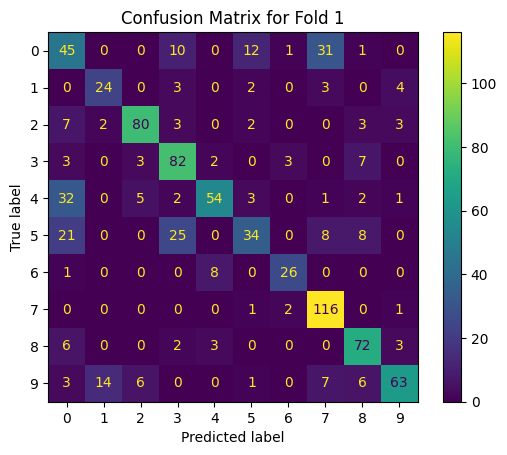

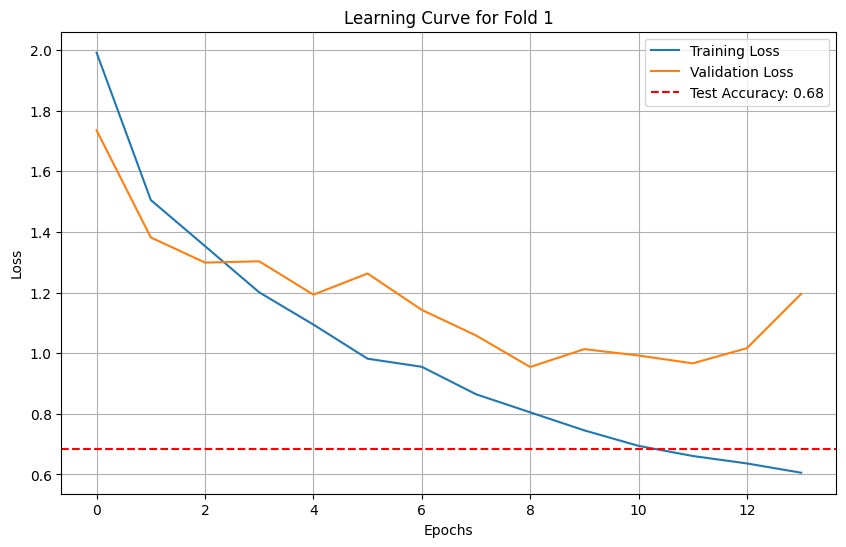

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2, Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.1985 - loss: 2.1263 - val_accuracy: 0.2789 - val_loss: 1.9015 - learning_rate: 0.0010
Validation Loss: 1.9015
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
Total misclassified: 667, Ratio: 0.1, Noisy samples to generate: 66
Added 66 noisy examples to the training set.
Fold 2, Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.3985 - loss: 1.6157 - val_accuracy: 0.3816 - val_loss: 1.7516 - learning_rate: 0.0010
Validation Loss: 1.7516
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step
Total misclassified: 572, Ratio: 0.1, Noisy samples to generate: 57
Added 57 noisy examples to the training set.
Fold 2, Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 112s 970ms/step - accuracy: 0.5072 - loss: 1.3669 - val_accuracy: 0.3946 - val_loss: 1.9557 - learning_rate: 0.0010
Validation Loss: 1.9557
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step
Total misclassified: 560, Ratio: 0.1, Noisy samples to generate: 56
Added 56 noisy examples t

Validation Loss: 1.3580
Early stopping triggered after 13 epochs. Best val_loss: 1.2971
Fold 2 Test Accuracy: 0.59
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step


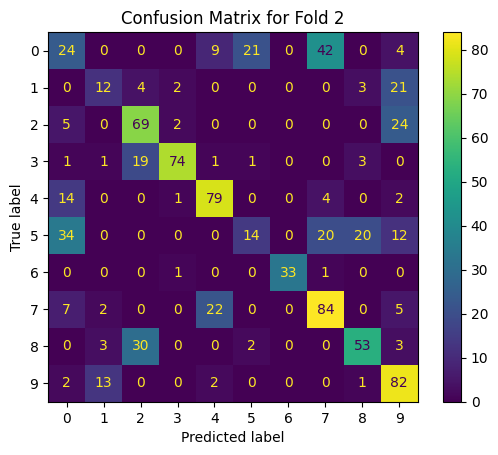

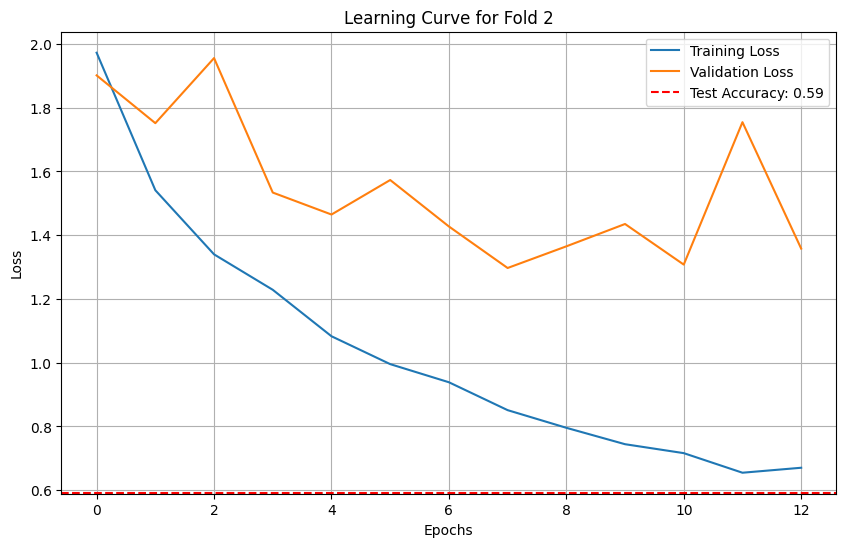

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3, Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.2067 - loss: 2.1192 - val_accuracy: 0.3505 - val_loss: 1.8144 - learning_rate: 0.0010
Validation Loss: 1.8144
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step
Total misclassified: 643, Ratio: 0.1, Noisy samples to generate: 64
Added 64 noisy examples to the training set.
Fold 3, Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 106s 965ms/step - accuracy: 0.4153 - loss: 1.5976 - val_accuracy: 0.4212 - val_loss: 1.6143 - learning_rate: 0.0010
Validation Loss: 1.6143
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step
Total misclassified: 573, Ratio: 0.1, Noisy samples to generate: 57
Added 57 noisy examples to the training set.
Fold 3, Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5082 - loss: 1.3792 - val_accuracy: 0.4535 - val_loss: 1.4829 - learning_rate: 0.0010
Validation Loss: 1.4829
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step
Total misclassified: 541, Ratio: 0.1, Noisy samples to generate: 54
Added 54 noisy examples t

Validation Loss: 1.1345
Early stopping triggered after 15 epochs. Best val_loss: 1.0014
Fold 3 Test Accuracy: 0.55
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step


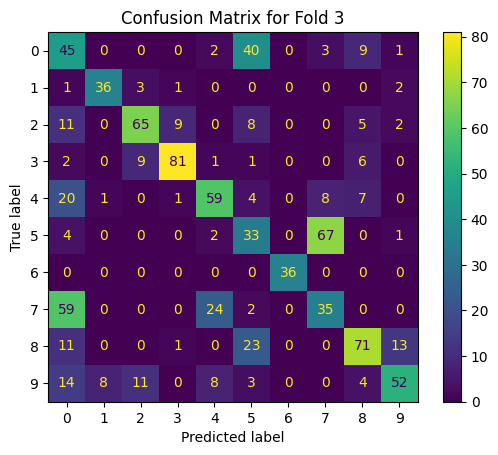

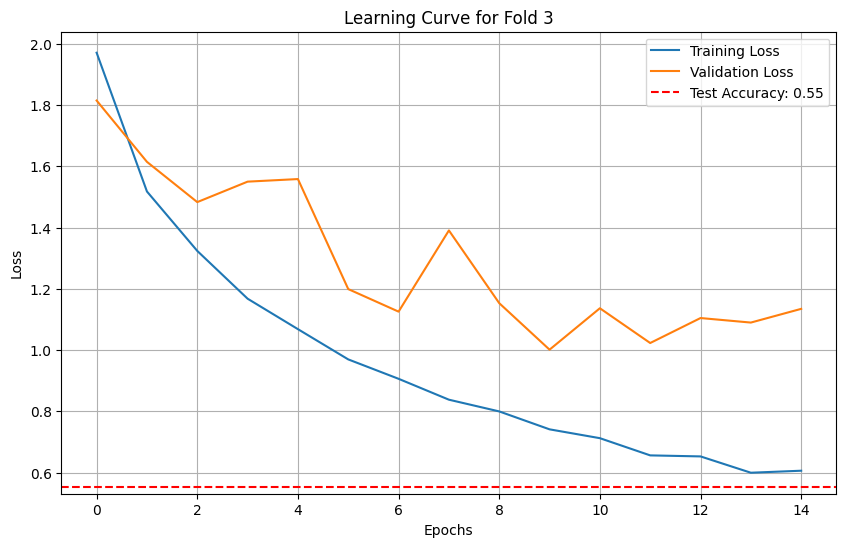

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4, Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.1854 - loss: 2.1538 - val_accuracy: 0.3120 - val_loss: 1.8161 - learning_rate: 0.0010
Validation Loss: 1.8161
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step
Total misclassified: 644, Ratio: 0.1, Noisy samples to generate: 64
Added 64 noisy examples to the training set.
Fold 4, Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 108s 981ms/step - accuracy: 0.4018 - loss: 1.6389 - val_accuracy: 0.4231 - val_loss: 1.5722 - learning_rate: 0.0010
Validation Loss: 1.5722
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
Total misclassified: 540, Ratio: 0.1, Noisy samples to generate: 54
Added 54 noisy examples to the training set.
Fold 4, Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.5155 - loss: 1.3796 - val_accuracy: 0.5427 - val_loss: 1.2363 - learning_rate: 0.0010
Validation Loss: 1.2363
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step
Total misclassified: 428, Ratio: 0.1, Noisy samples to generate: 42
Added 42 noisy examples t

Validation Loss: 0.9329
Early stopping triggered after 18 epochs. Best val_loss: 0.7819
Fold 4 Test Accuracy: 0.63
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step


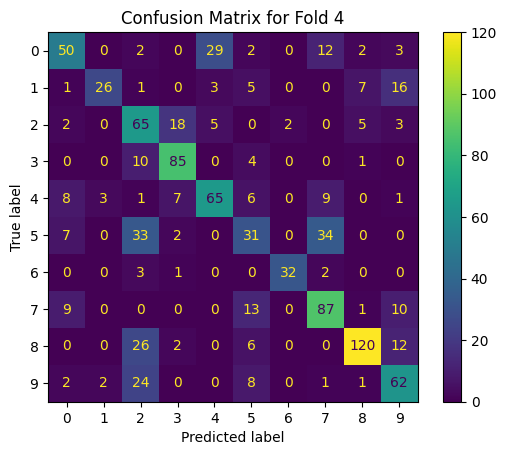

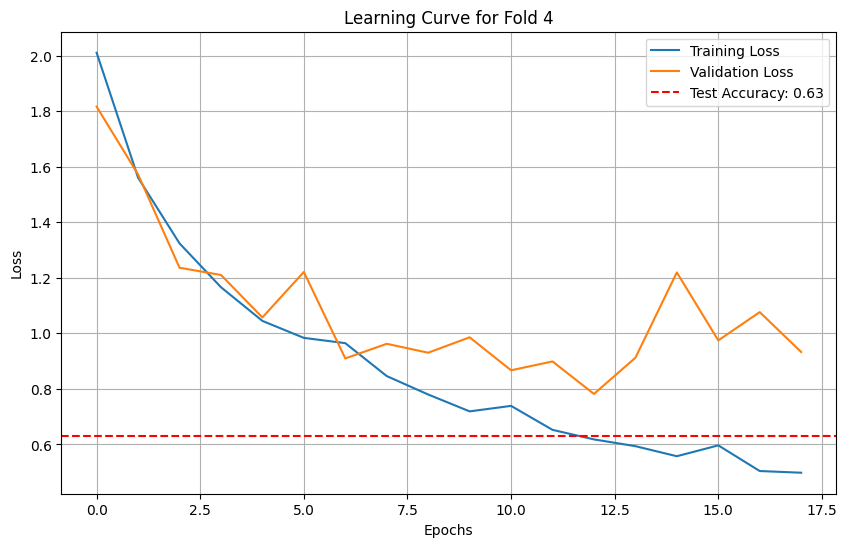

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5, Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.2140 - loss: 2.1031 - val_accuracy: 0.3864 - val_loss: 1.8001 - learning_rate: 0.0010
Validation Loss: 1.8001
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
Total misclassified: 505, Ratio: 0.1, Noisy samples to generate: 50
Added 50 noisy examples to the training set.
Fold 5, Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 102s 907ms/step - accuracy: 0.4370 - loss: 1.5678 - val_accuracy: 0.4326 - val_loss: 1.6642 - learning_rate: 0.0010
Validation Loss: 1.6642
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step
Total misclassified: 467, Ratio: 0.1, Noisy samples to generate: 46
Added 46 noisy examples to the training set.
Fold 5, Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 107s 942ms/step - accuracy: 0.5267 - loss: 1.3280 - val_accuracy: 0.4374 - val_loss: 1.5467 - learning_rate: 0.0010
Validation Loss: 1.5467
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step
Total misclassified: 463, Ratio: 0.1, Noisy samples to generate: 46
Added 46 noisy example

Validation Loss: 1.4103
Early stopping triggered after 13 epochs. Best val_loss: 1.3515
Fold 5 Test Accuracy: 0.63
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step


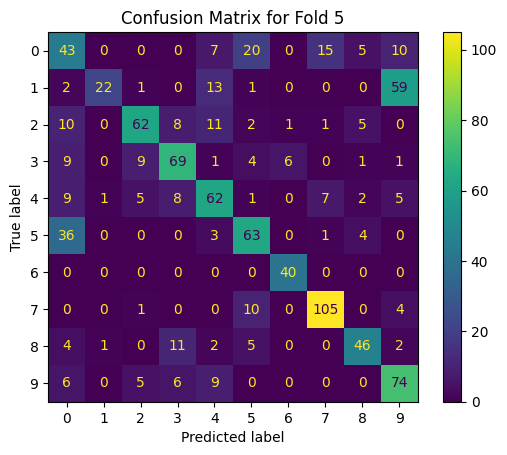

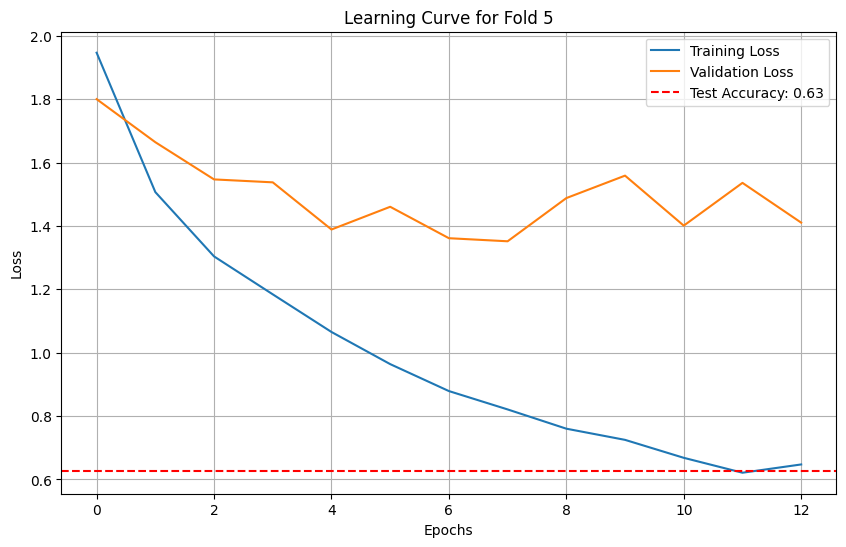

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6, Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2073 - loss: 2.0972 - val_accuracy: 0.4045 - val_loss: 1.6195 - learning_rate: 0.0010
Validation Loss: 1.6195
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step
Total misclassified: 499, Ratio: 0.1, Noisy samples to generate: 49
Added 49 noisy examples to the training set.
Fold 6, Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.4339 - loss: 1.5225 - val_accuracy: 0.4964 - val_loss: 1.3688 - learning_rate: 0.0010
Validation Loss: 1.3688
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step
Total misclassified: 422, Ratio: 0.1, Noisy samples to generate: 42
Added 42 noisy examples to the training set.
Fold 6, Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5189 - loss: 1.3239 - val_accuracy: 0.5919 - val_loss: 1.2505 - learning_rate: 0.0010
Validation Loss: 1.2505
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step
Total misclassified: 342, Ratio: 0.1, Noisy samples to generate: 34
Added 34 noisy examples to t

Validation Loss: 0.8861
Early stopping triggered after 14 epochs. Best val_loss: 0.7842
Fold 6 Test Accuracy: 0.63
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step


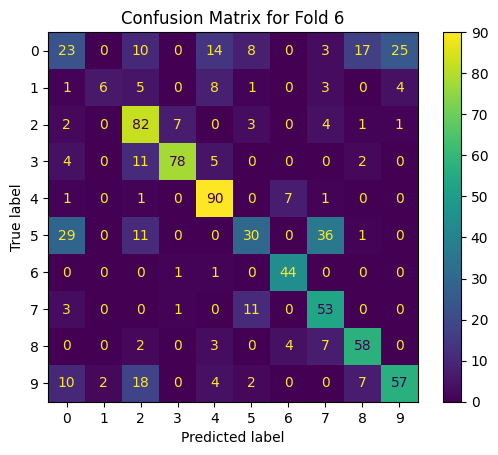

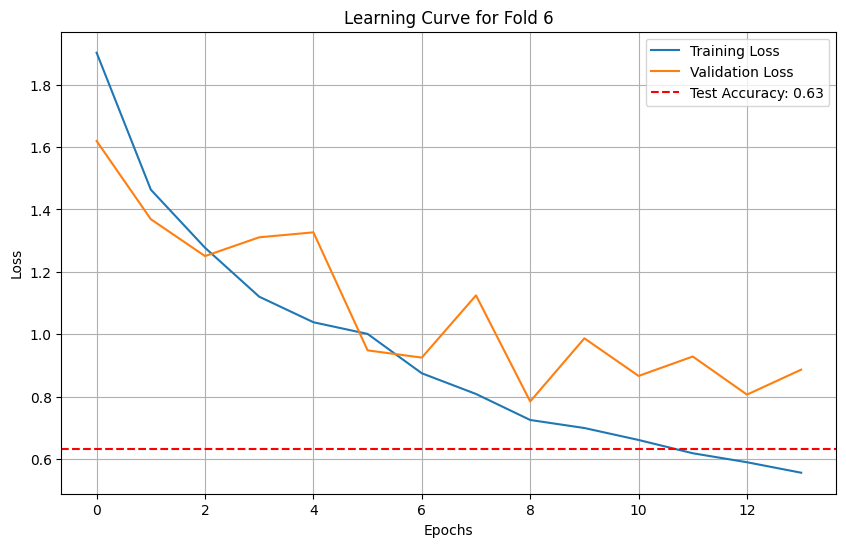

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7, Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 114s 988ms/step - accuracy: 0.2043 - loss: 2.1310 - val_accuracy: 0.3189 - val_loss: 1.7345 - learning_rate: 0.0010
Validation Loss: 1.7345
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step
Total misclassified: 549, Ratio: 0.1, Noisy samples to generate: 54
Added 54 noisy examples to the training set.
Fold 7, Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 110s 952ms/step - accuracy: 0.4136 - loss: 1.6155 - val_accuracy: 0.4665 - val_loss: 1.5812 - learning_rate: 0.0010
Validation Loss: 1.5812
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step
Total misclassified: 430, Ratio: 0.1, Noisy samples to generate: 43
Added 43 noisy examples to the training set.
Fold 7, Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 114s 959ms/step - accuracy: 0.5180 - loss: 1.3240 - val_accuracy: 0.4615 - val_loss: 1.6628 - learning_rate: 0.0010
Validation Loss: 1.6628
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step
Total misclassified: 434, Ratio: 0.1, Noisy samples to generate: 43
Added 43 noisy exam

Validation Loss: 1.3642
Early stopping triggered after 17 epochs. Best val_loss: 1.1711
Fold 7 Test Accuracy: 0.66
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step


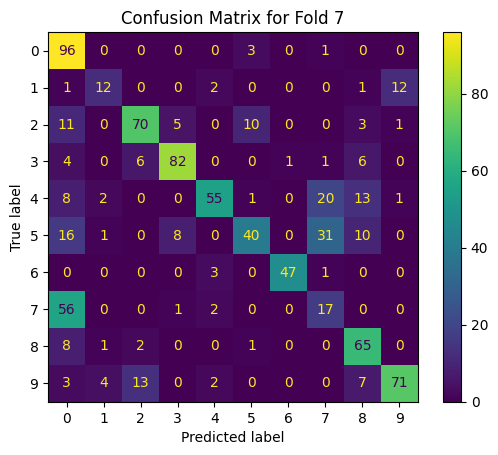

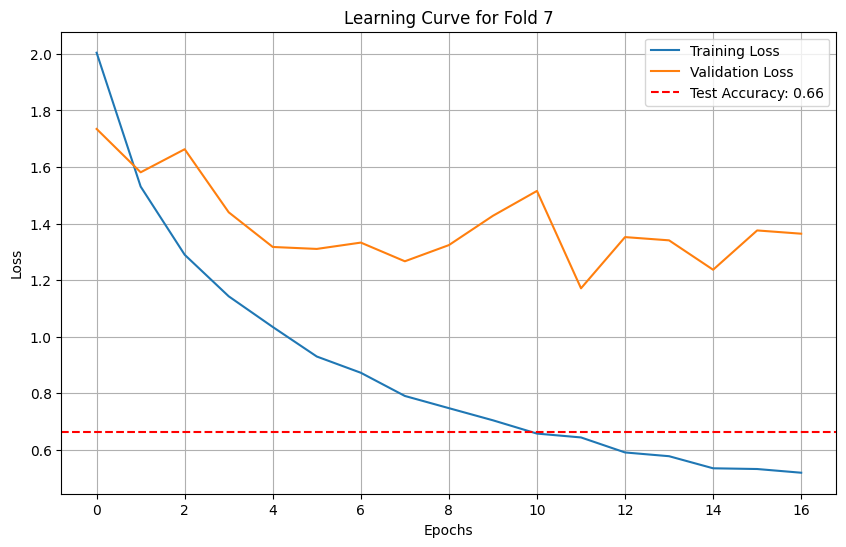

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8, Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.2130 - loss: 2.0879 - val_accuracy: 0.4498 - val_loss: 1.5064 - learning_rate: 0.0010
Validation Loss: 1.5064
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step
Total misclassified: 449, Ratio: 0.1, Noisy samples to generate: 44
Added 44 noisy examples to the training set.
Fold 8, Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 113s 999ms/step - accuracy: 0.4574 - loss: 1.5101 - val_accuracy: 0.4534 - val_loss: 1.4642 - learning_rate: 0.0010
Validation Loss: 1.4642
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step
Total misclassified: 446, Ratio: 0.1, Noisy samples to generate: 44
Added 44 noisy examples to the training set.
Fold 8, Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.5363 - loss: 1.3234 - val_accuracy: 0.5784 - val_loss: 1.3189 - learning_rate: 0.0010
Validation Loss: 1.3189
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step
Total misclassified: 344, Ratio: 0.1, Noisy samples to generate: 34
Added 34 noisy examples t

Validation Loss: 0.9428
Early stopping triggered after 21 epochs. Best val_loss: 0.8804
Fold 8 Test Accuracy: 0.65
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step


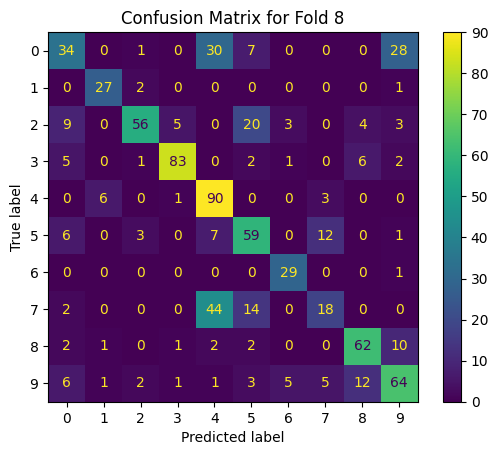

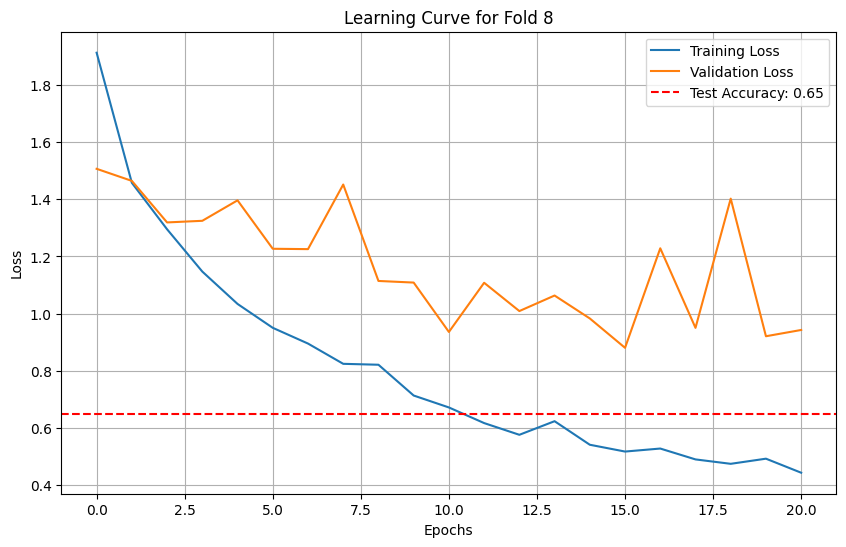

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9, Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 116s 976ms/step - accuracy: 0.2150 - loss: 2.1003 - val_accuracy: 0.3405 - val_loss: 1.6528 - learning_rate: 0.0010
Validation Loss: 1.6528
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step
Total misclassified: 552, Ratio: 0.1, Noisy samples to generate: 55
Added 55 noisy examples to the training set.
Fold 9, Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 100s 877ms/step - accuracy: 0.4318 - loss: 1.5530 - val_accuracy: 0.4827 - val_loss: 1.4556 - learning_rate: 0.0010
Validation Loss: 1.4556
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step
Total misclassified: 433, Ratio: 0.1, Noisy samples to generate: 43
Added 43 noisy examples to the training set.
Fold 9, Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 109s 949ms/step - accuracy: 0.5172 - loss: 1.3791 - val_accuracy: 0.5114 - val_loss: 1.3688 - learning_rate: 0.0010
Validation Loss: 1.3688
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
Total misclassified: 409, Ratio: 0.1, Noisy samples to generate: 40
Added 40 noisy exam

Validation Loss: 0.7536
Early stopping triggered after 24 epochs. Best val_loss: 0.6622
Fold 9 Test Accuracy: 0.75
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step


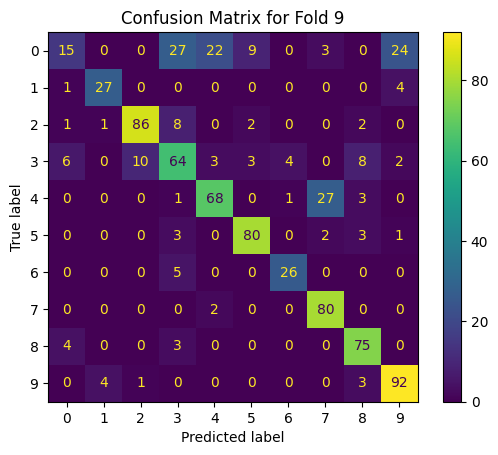

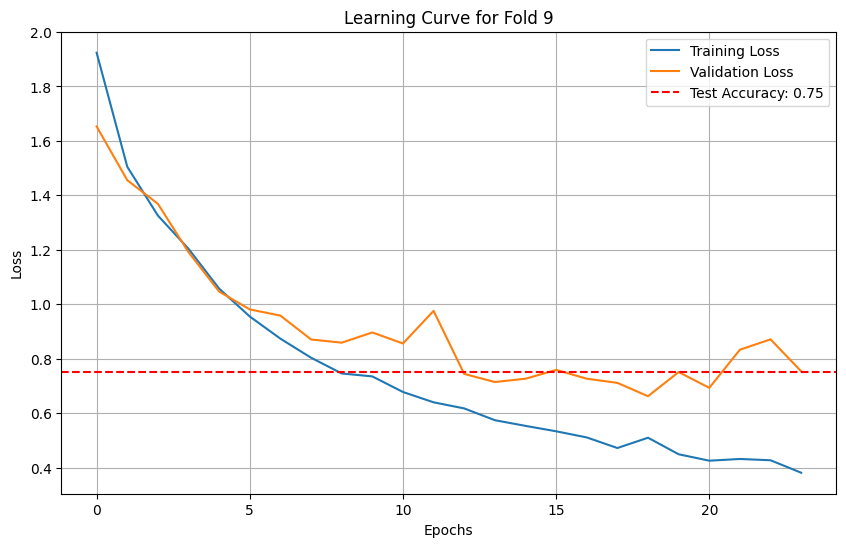

C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10, Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 1000ms/step - accuracy: 0.2129 - loss: 2.1113 - val_accuracy: 0.4444 - val_loss: 1.6236 - learning_rate: 0.0010
Validation Loss: 1.6236
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step
Total misclassified: 485, Ratio: 0.1, Noisy samples to generate: 48
Added 48 noisy examples to the training set.
Fold 10, Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 100s 880ms/step - accuracy: 0.4447 - loss: 1.5539 - val_accuracy: 0.4296 - val_loss: 1.5345 - learning_rate: 0.0010
Validation Loss: 1.5345
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step
Total misclassified: 498, Ratio: 0.1, Noisy samples to generate: 49
Added 49 noisy examples to the training set.
Fold 10, Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 108s 930ms/step - accuracy: 0.5155 - loss: 1.3477 - val_accuracy: 0.4880 - val_loss: 1.5568 - learning_rate: 0.0010
Validation Loss: 1.5568
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step
Total misclassified: 447, Ratio: 0.1, Noisy samples to generate: 44
Added 44 noisy 

Validation Loss: 1.1517
Early stopping triggered after 18 epochs. Best val_loss: 0.7920
Fold 10 Test Accuracy: 0.70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step


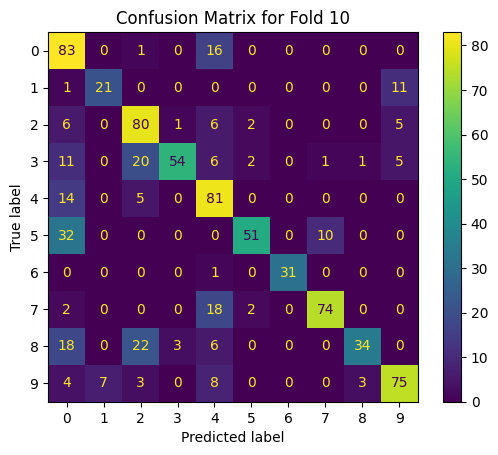

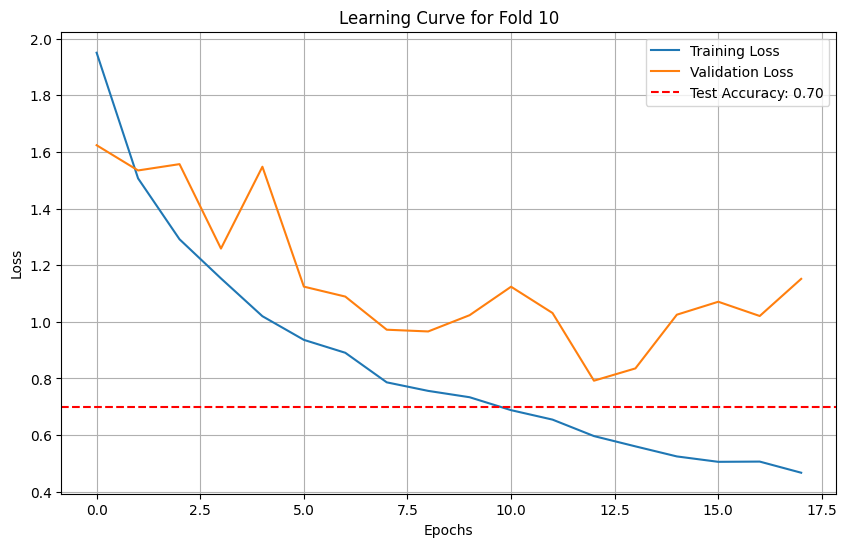

In [ ]:

for fold_idx, test_fold in enumerate(folds):
    validation_fold = folds[(fold_idx + 1) % 10]  # Use the next fold as validation
    train_folds = [f for f in folds if f not in [test_fold, validation_fold]]

    # Load data
    X_train, y_train = load_data(train_folds, processed_dir)
    X_val, y_val = load_data([validation_fold], processed_dir)
    X_test, y_test = load_data([test_fold], processed_dir)

    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    y_train = np.reshape(y_train, (-1, num_classes))
    y_val = np.reshape(y_val, (-1, num_classes))
    y_test = np.reshape(y_test, (-1, num_classes))



    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    
    max_epochs = 50
    patience_limit = 5
    early_stop_counter = 0
    best_val_loss = float('inf')
    best_weights = None
    history = []

    for epoch in range(1, max_epochs + 1):
        print(f"Fold {fold_idx + 1}, Epoch {epoch}/{max_epochs}")

        
        hist = model.fit(
            X_train,
            y_train,
            batch_size=64,
            epochs=1,
            validation_data=(X_val, y_val),
            verbose=1,
            callbacks=[early_stopping, reduce_lr]
        )

        # Store history
        history.append(hist.history)

        # Extract validation loss
        val_loss = hist.history.get('val_loss', [None])[-1]
        if val_loss is not None:
            print(f"Validation Loss: {val_loss:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = model.get_weights()  # Save best weights
                early_stop_counter = 0
            else:
                early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience_limit:
            print(f"Early stopping triggered after {epoch} epochs. Best val_loss: {best_val_loss:.4f}")
            model.set_weights(best_weights)  # Restore best weights
            break

        # Generate noisy examples and augment training data
        X_noisy, y_noisy = generate_noisy_examples(X_val, y_val, model, noise_factor=0.05, ratio=0.1)
        if len(X_noisy) > 0:
            X_train = np.concatenate([X_train, X_noisy])
            y_train = np.concatenate([y_train, y_noisy])
            print(f"Added {len(X_noisy)} noisy examples to the training set.")

    
    model.save(f"model_fold_{fold_idx + 1}.h5")

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_idx + 1} Test Accuracy: {test_accuracy:.2f}")

    # Compute confusion matrix
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for Fold {fold_idx + 1}")
    plt.show()

    
    plot_learning_curve(history, test_accuracy, fold_idx)


## 6. Model Evaluation

In the cross validation is possible to see that the model overffits more rappidly in some folds that other but overall gives consistent results its also worth noticing that if the models pacience limit currently at 6 was incresied the performance on some folds could be better but due to hardware limitations the model on some folds may have a performance slightly worse than if the model had run for more time.

## 7. Final Remarks

The biggest obstacle faced in this project was the needed to run a model an have a good insite if the performance improved or not